Assignment 2


In [1]:
import numpy as np
import cv2 
import matplotlib . pyplot as plt
import random

In this assignment, we will practice object recognition and robust model fitting with RANSAC for homography estimation. We want to locate a given reference object in another image of a scene which contains that object (and eventually many other objects). 
In the first section, we have to extract features that takes input an image, convert it to grayscale and then apply standard cv SIFT to get keypoints and descriptors. It also returns the amount of keypoints pointed out in each image.

In [2]:
def extract_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Initialize the SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    # Return keypoints and descriptors
    return keypoints, descriptors, len(keypoints)

To filter out only best 1000 keypoints from all the detected ones, we will first have to sort out the keypoints and then grab the grab the first 1000 of them

In [5]:
def get_good_keypoints(keypoints, N=1000):
    # Sort keypoints by response value
    sorted_keypoints = sorted(keypoints, key=lambda x: -x.response)
    # Get the N best keypoints
    good_keypoints = sorted_keypoints[:N]
    return good_keypoints

According to assignment, we have to modify our feature extraction by filtering out only the better 1000 features with certain threshold of Contrast, so we implemented the better version of keypoint and descriptor extraction

In [3]:
def extract_features_with_contrast(image, contrastThreshold=0.02, nfeatures=1000):
     # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize the SIFT detector with specified parameters
    sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=0.02, nfeatures=1000)

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    return keypoints, descriptors

We also have to apply the 1NN/2NN ratio test for removing some ambiguous correspondences, It is just defined here but it will be applied after the matches have been found. It takes input matches and distances and find the closest distances under certain threshold and thus filter out good matches

In [4]:
def perfrom_1NN(matches, sorted_distances, ratio_thresh=0.7):
    good_matches = []
    for i, (m, dist) in enumerate(zip(matches, sorted_distances)):
        if dist[0] < ratio_thresh * dist[1]:
            good_matches.append(cv2.DMatch(i, m[1], dist[0]))

    return good_matches

Now we are going to store all the images in an array and then try to detect keypoints in them and also print the number of keypoints it detected through the first function. Also there is function declared to display the images.

In [1]:
def display_images(img, keypoints):
    # Draw keypoints on the input image
    image_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Display the image with keypoints
    cv2.imshow('Image with keypoints', image_with_keypoints)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
# List of image paths
image_paths = ['data/esirem.jpg', 'data/img_1.jpg', 'data/img_2.png', 'data/img_3.jpg', 'data/img_4.jpg', 'data/img_ref.jpg']
# List to store number of keypoints for each image
num_keypoints_list = []
# Process each image and store number of keypoints
for image_path in image_paths:
    #Load the image
    image = cv2.imread(image_path)

    # Extract features and keypoints
    keypoints, descriptors, num_keypoints = extract_features(image)
    keypoints, descriptors = extract_features_with_contrast(image)

    # Extract good keypoints and display
    good_keypoints= get_good_keypoints(keypoints, 1000) 
    
    display_images(image, good_keypoints)

    # Append number of keypoints to list
    num_keypoints_list.append(num_keypoints)

# Print the number of keypoints detected in each image
for i, num_keypoints in enumerate(num_keypoints_list):
    print('Image {}: {} keypoints'.format(i+1, num_keypoints))

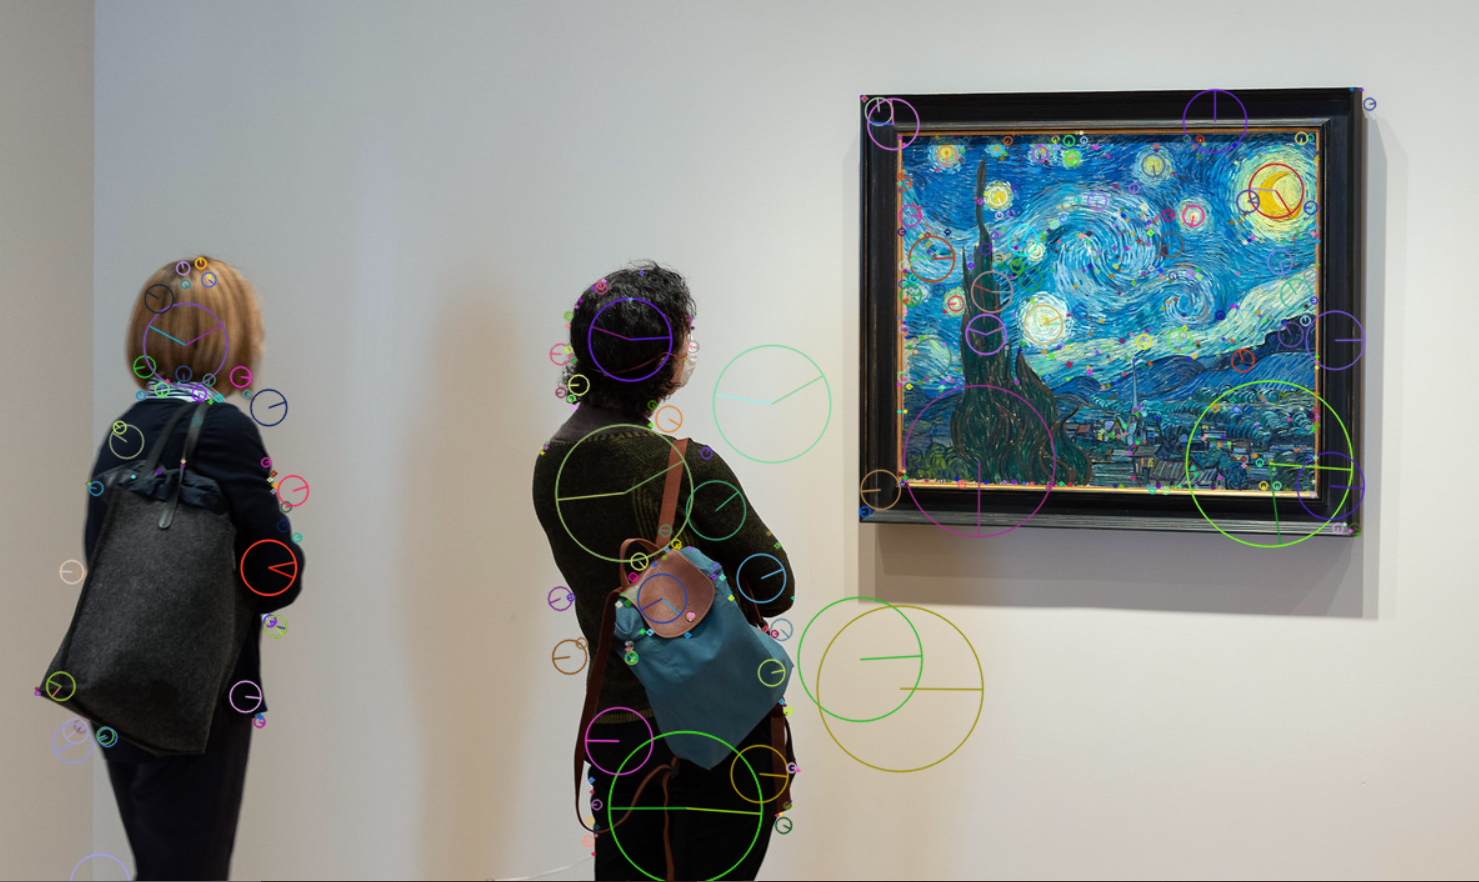

In the next function, we first compute the pairwise distances between the descriptors, which we store in the dists matrix. We then find the matches with the smallest distance by taking the index of the minimum value in each row of the dists matrix using np.argmin(dists, axis=1).

Next, we sort the matches based on their distance using np.argsort(dists, axis=1), which returns the indices that would sort each row of the dists matrix. We then use np.take_along_axis(dists, sorted_indices, axis=1) to sort the dists matrix based on the sorted indices. Finally, we stack the row indices and the first column of the sorted indices to get the list of matches, which we return.

As before, we draw the top 30 matches on the images using cv2.drawMatches(). We also implemented cv2.drawMatchesKnn to target keypoints instead of the matches.

In [2]:
def find_matches(image1, keypoints1, descriptors1, image2, keypoints2, descriptors2):
    # Compute the pairwise distances between descriptors
    dists = np.sqrt(((descriptors1[:, np.newaxis, :] - descriptors2)**2).sum(axis=2))

    # Find the matches with the smallest distance
    matches = np.argmin(dists, axis=1)

    # Sort the matches by distance (lower is better)
    sorted_indices = np.argsort(dists, axis=1)
    sorted_dists = np.take_along_axis(dists, sorted_indices, axis=1)
    matches = np.stack([np.arange(len(matches)), sorted_indices[:, 0]], axis=1)

    # Convert matches to a list of DMatch objects
    dmatches = [cv2.DMatch(m[0], m[1], sorted_dists[i, 0]) for i, m in enumerate(matches)]

    good_matches = perfrom_1NN (matches, sorted_dists, 0.7)

    # Draw the top 10 matches on the images
    #matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, dmatches[:30], None, matchColor=(0, 255, 0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    matched_image = cv2.drawMatchesKnn(image1, keypoints1, image2, keypoints2, [good_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


    # Display the image with the matches
    resize_matched= cv2.resize(matched_image, (960, 540)) 
    cv2.imshow('Matches', resize_matched)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Return the list of matches
    return matches, sorted_dists

Now we are going to detect the keypoints both from refernce image and the target image and then compare the matches. We also performed the 1NN ratio we defined earlier.

In [8]:
image1 = cv2.imread("data/img_ref.jpg")
keypoints1, descriptors1 = extract_features_with_contrast(image1)
good_keypoints1= get_good_keypoints(keypoints1, 1000) 


image2 = cv2.imread("data/img_3.jpg")
keypoints2, descriptors2 = extract_features_with_contrast(image2)
good_keypoints2= get_good_keypoints(keypoints2, 1000) 

matches, sorted_distances= find_matches(image1, keypoints1, descriptors1, image2, keypoints2, descriptors2)
good_matches= perfrom_1NN(matches, sorted_distances, 0.7)

This is the result when we used cv2.drawMatches
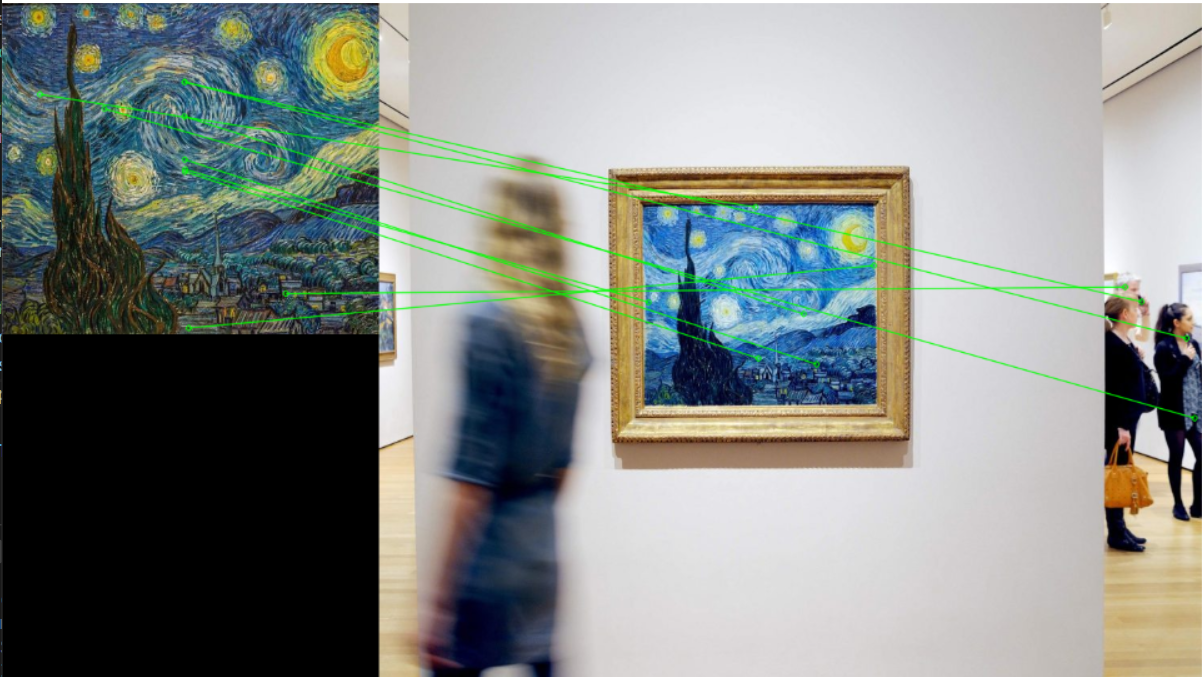

This is the result of cv2.drawMatchesKnn
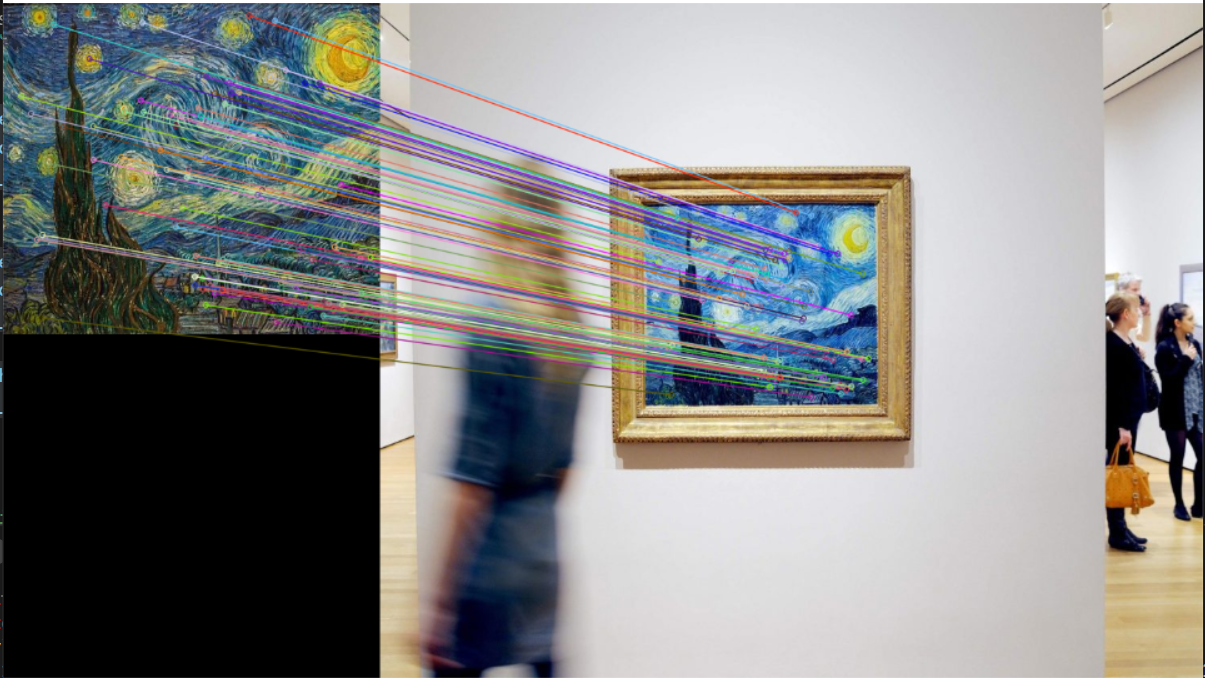

In the second phase of the assignment, we had to look into the 2D homography transformation.
For fitting a 2D homography transformation model, we need at least 4 corresponding 2D points. These points should be non-collinear, meaning that they should not lie on a straight line.

If we have more than 4 corresponding 2D points, we can use a least-squares estimation method to compute the best-fit homography that maps one set of points to the other.

The homography transformation is a 3x3 matrix that maps the coordinates of one set of points to the corresponding coordinates in the other set. 

The algorithm mentioned in the image provided inside the assignment document is known as the Direct Linear Transformation (DLT) algorithm for computing the homography matrix. Here are the steps of the algorithm:

Normalization of points x: Compute a similarity transformation T that takes the points x to a new set of points x' such that the centroid of the points is at the origin (0,0) and their average distance from the origin is sqrt(2).

Normalization of points x': Compute a similarity transformation T' for the points in the second image, transforming points x' to x''.

DLT: Apply the DLT algorithm to the correspondences between the normalized points x' and x'' to obtain a homography matrix H.

Denormalization: Compute the homography matrix H' = inv(T') * H * T, which maps the original points x to the corresponding points x'' in the second image.

The DLT algorithm works by solving a linear system of equations that relates the coordinates of the points in the two images to the elements of the homography matrix H. The linear system can be solved using singular value decomposition (SVD) or other numerical methods.

In [3]:
def find_homography(src_pts, dst_pts):
    num_pts = src_pts.shape[0]

    # Normalization of x
    centroid1 = np.mean(src_pts, axis=0)
    scale1 = np.sqrt(2) / np.mean(np.linalg.norm(src_pts - centroid1, axis=1))
    print (centroid1[0][0])
    
    T1 = np.array([[scale1, 0, -scale1 * centroid1[0][0]],
                   [0, scale1, -scale1 * centroid1[0][1]],
                   [0, 0, 1]])

    src_h = np.concatenate([src_pts.reshape(-1, src_pts.shape[-1]), np.ones((num_pts, 1))], axis=1)
    norm_src_pts = np.dot(T1, src_h.T).T[:, :2]

    # Normalization of x'
    centroid2 = np.mean(dst_pts, axis=0)
    scale2 = np.sqrt(2) / np.mean(np.linalg.norm(dst_pts - centroid2, axis=1))
    T2 = np.array([[scale2, 0, -scale2 * centroid2[0][0]],
                   [0, scale2, -scale2 * centroid2[0][1]],
                   [0, 0, 1]])

    dst_h = np.concatenate([dst_pts.reshape(-1, dst_pts.shape[-1]), np.ones((num_pts, 1))], axis=1)
    norm_dst_pts = np.dot(T2, dst_h.T).T[:, :2]

    # Direct Linear Transform (DLT)
    A = []
    for i in range(num_pts):
        x, y = norm_src_pts[i]
        xp, yp = norm_dst_pts[i]
        A.append([x, y, 1, 0, 0, 0, -xp * x, -xp * y, -xp])
        A.append([0, 0, 0, x, y, 1, -yp * x, -yp * y, -yp])
    A = np.array(A)

    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape((3, 3))

    # Denormalization
    H = np.dot(np.linalg.inv(T2), np.dot(H, T1))

    return H / H[2, 2]



The built-in function provided inside the assignment

In [4]:
def render_warped_texture (H , img_ref , img_tgt , patch_texture) :
    ## warp patch texture that will be placed in the selected region with
    # the estimated homography transformation H
    h , w , _ = img_ref.shape
    patch_texture_res = cv2.resize(patch_texture, (w ,h))
    warped_patch = cv2.warpPerspective(patch_texture_res, H, (img_tgt.shape[1],img_tgt.shape[0]) )
    ## remove the pixels of the foreground that will be replaced (we keep only background )
    mask = (255* np.ones((h , w))).astype(np.uint8)
    mask_warped = cv2.warpPerspective(mask, H, (img_tgt.shape[1], img_tgt.shape[0]), flags=cv2.INTER_NEAREST )
    mask_background = (1 - mask_warped /255).astype (np.uint8)
    mask_background = cv2.merge(( mask_background, mask_background, mask_background))
    background = cv2 . multiply ( mask_background, img_tgt)

    # blend images to a single frame and display
    blend_img = cv2.add (background, warped_patch)
    plt.figure (figsize =(20, 10))
    plt.imshow ( cv2.cvtColor (blend_img , cv2.COLOR_BGR2RGB ) )
    plt.axis ('off')
    plt.show ()

Now we try to test out homography algorithm

In [8]:
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

H= find_homography(pts1, pts2)
patch_texture = cv2.imread("data/esirem.jpg")
render_warped_texture(H, image1, image2, patch_texture)

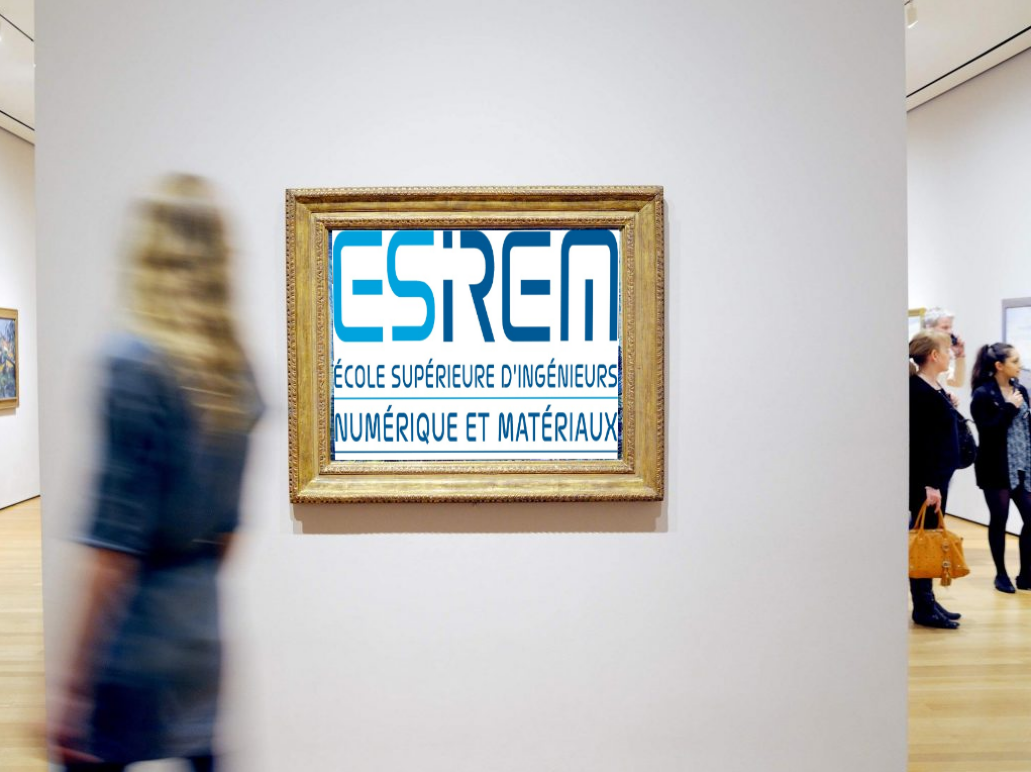

Now we have to develop our own Ransac homography function, based on the recipe of Ransac algorithm provided in the image of the assignment. I did that in three steps, first will only normalize the input points, the second will will apply DLT and also denormalise it. The third one is the main one that radomly selects S data points based on the instructions and calculates inliers based on the distances.

In [6]:
def normalize_points(points):
    # Compute the centroid of the points
    centroid = np.mean(points, axis=0)

    # Compute the average distance of points to the centroid
    avg_dist = np.sqrt(np.mean(np.sum((points - centroid) ** 2, axis=1)))

    # Compute the scaling factor
    scale = np.sqrt(2) / avg_dist

    # Compute the transformation matrix
    T = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[0]],
        [0, 0, 1]
    ])

    # Apply the transformation matrix to the points
    homog_points = np.hstack([points, np.ones((points.shape[0], 1))])[:, :3]
    norm_points = T @ homog_points.T
    norm_points = (norm_points / norm_points[2, :])[:2, :].T

    return norm_points, T

In [5]:
def calculate_homography(src_pts, dst_pts):
    # Convert points to homogeneous coordinates
    src_h = np.concatenate([src_pts.reshape(-1, 2), np.ones((src_pts.shape[0], 1))], axis=1)
    dst_h = np.concatenate([dst_pts.reshape(-1, 2), np.ones((dst_pts.shape[0], 1))], axis=1)

    # Normalize the points to improve numerical stability
    src_h_norm, T1 = normalize_points(src_h)
    dst_h_norm, T2 = normalize_points(dst_h)

    # Construct the A matrix for the homogeneous linear system
    A = []
    for i in range(src_h_norm.shape[0]):
        x, y = src_h_norm[i]
        u, v= dst_h_norm[i]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.array(A)
    print(A)
    # Solve the homogeneous linear system using SVD
    U, s, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))

    # Denormalize the homography
    H = np.dot(np.linalg.inv(T2), np.dot(H, T1))

    return H

In [12]:
def homography_RANSAC(src_pts, dst_pts, threshold=5, num_iterations=1000, min_inliers=30):
    best_H = None
    best_inliers = []
    for i in range(num_iterations):
        # Step 1: Randomly select a sample of s data points from S and instantiate the model from this subset
        idx = np.random.choice(src_pts.shape[0], 4, replace=False)
        src_sample = src_pts[idx]
        dst_sample = dst_pts[idx]
        H = calculate_homography(src_sample, dst_sample)

        # Step 2: Determine the set of data points Si which are within a distance threshold t of the model.
        inliers = []
        for j in range(src_pts.shape[0]):
            x = src_pts[j]
            x_prime = dst_pts[j]
            x_prime_estimate = np.dot(H, np.concatenate((x.reshape(-1, 1), np.ones((1,1))), axis=0))
            x_prime_estimate /= x_prime_estimate[2]
            dist = np.linalg.norm(x_prime - x_prime_estimate[:-1])
            if dist < threshold:
                inliers.append(j)

        # Step 3: If the size of Si (the number of inliers) is greater than some threshold T, re-estimate the model using all the points in Si and terminate.
        if len(inliers) >= min_inliers:
            inliers_src = src_pts[inliers]
            inliers_dst = dst_pts[inliers]
            H = calculate_homography(inliers_src, inliers_dst)
            return H, inliers

        # Step 4: If the size of Si is less than T, select a new subset and repeat the above.
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H

    # Step 5: After N trials the largest consensus set .S'i is selected, and the model is re-estimated using all the points in the subset Si.
    inliers_src = src_pts[best_inliers]
    inliers_dst = dst_pts[best_inliers]
    best_H = calculate_homography(inliers_src, inliers_dst)
    return best_H, best_inliers

Unfortunately, i was unable to provide its output, because it was giving me different errors based on the different input images so i could not understand the real issue in it.

Next we will implement a function to apply same thing using cv.

In [7]:
def detect_homography_cv(src_pts, dst_pts, method=cv2.RANSAC, ransac_reproj_thresh=3.0):
    # Ensure that the input points are of the correct type and shape
    src_pts = src_pts.astype(np.float32)
    dst_pts = dst_pts.astype(np.float32)
    assert src_pts.shape == dst_pts.shape

    # Detect the homography using OpenCV
    H, mask = cv2.findHomography(src_pts, dst_pts, method=method, ransacReprojThreshold=ransac_reproj_thresh)

    # Ensure that the homography matrix is of the correct shape
    H = H.reshape((3, 3))

    return H

NameError: name 'cv2' is not defined

This is the output we got
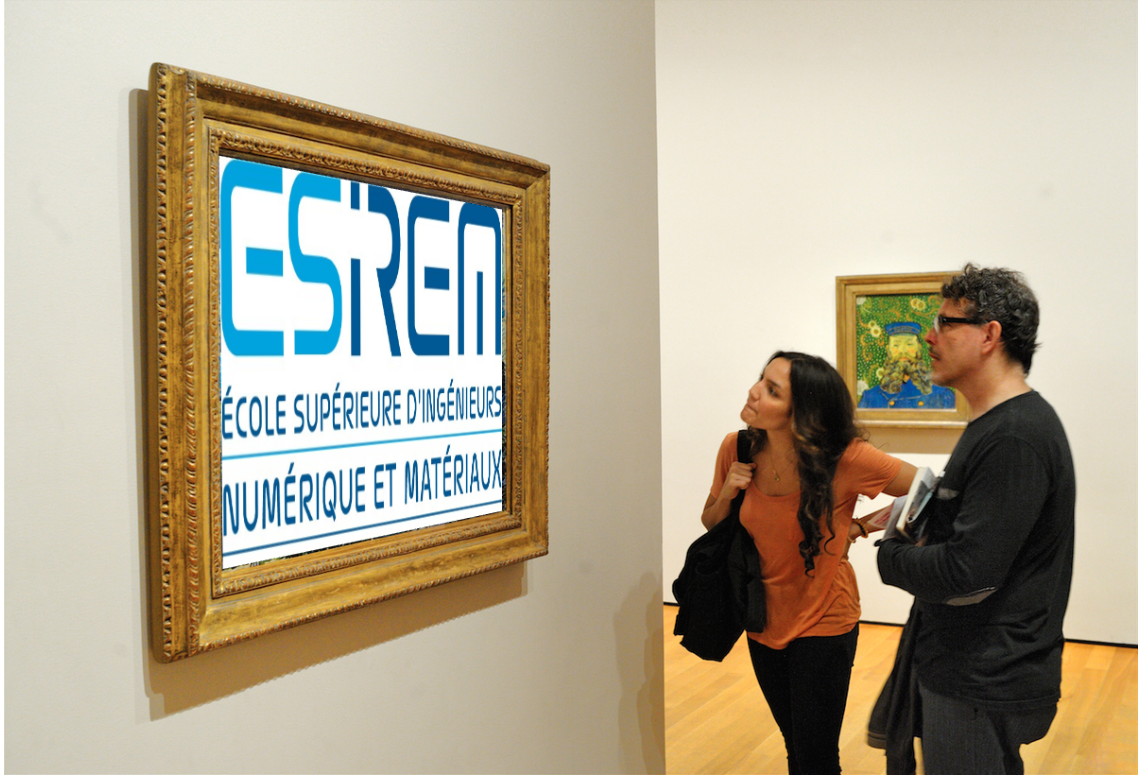